<img src=https://raw.githubusercontent.com/hoittoken/Python/master/Py/project_3/logo.png>

# Содержание <a class="anchor" id=0></a>

* [1. Кейс. Задача. Метрика](#1)
* [2. Библиотеки и загрузка данных](#2)
* [3. Дубли и пропуски](#3)
* [4. Признак *hotel_address*](#4)
* [5. Признак *review_date*](#5)
* [6. Признак *reviewer_nationality*](#6)
* [7. Признак *tags*](#7)
* [8. Лингвистический анализ](#8)
* [9. Отбор признаков](#9)
* [10. Обучение модели. Метрика. Submission](#10)

# 1. Кейс. Задача. Метрика <a class="anchor" id=1></a> <a id="1"></a> <br>

[к содержанию](#0)

### **Кейс**: Компании Booking борится с накруткой рейтингов отелей. 

### **Задача**: Выявить нечестные отели (те что накручивают рейтинг).

### **Решение**: Построение модели предсказывающей рейтинг отеля на основание доступных данных. При значительном расхождении предсказанного с реальным рейтингом проводить более детальную проверку отеля.

### **Метрика**: *`MAPE (mean absolute percentage error)`* , средняя абсолютная процентная ошибка между фактическими значениями и предсказанными значениями рейтинга отеля.

# 2. Библиотеки и загрузка данных <a class="anchor" id=2></a> <a id="2"></a> <br>

[к содержанию](#0)

In [1]:
# Импортируем основные библиотеки

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# для визуализаций
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для определения расстояний
from geopy.distance import geodesic

# для кодирования
import category_encoders as ce

# для подсчёта всякого
from collections import Counter

# для определения тональности отзывов:
from textblob import TextBlob 

# для разделения датасета:
from sklearn.model_selection import train_test_split

# инструменты для построения модели:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


## Определим некоторые константы


In [2]:
# Зафиксируем random_seed
RANDOM_SEED = 42

# Зафиксируем требования
#!pip freeze > requirements.txt

In [3]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [6]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 3. Дубли и пропуски <a class="anchor" id=3></a> <a id="3"></a> <br>

[к содержанию](#0)

### Проверим на дубли тренировочный и тестовый сеты

In [7]:
print(f'Количество дублей в тренировочном сете: {df_train[df_train.duplicated()].shape[0]}')
print(f'Количество дублей в тестовом сете: {df_test[df_test.duplicated()].shape[0]}')

Количество дублей в тренировочном сете: 307
Количество дублей в тестовом сете: 29


### Из тренировочного сета дубли удаляем, с тестовым сложнее. На него завязан финальный сабмит, пока оставим как есть.

<img src=https://raw.githubusercontent.com/hoittoken/Python/master/Py/project_3/mem_1.png>

In [8]:
# Безжалостно удалим дубли в тренировочном сете
df_train = df_train.drop_duplicates()

In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

### NaN'ы есть только в столбцах lat и lng, а они завязаны на признак `hotel_address`, приступим к обработке признаков.

# 4. Признак `hotel_address` <a class="anchor" id=4></a> <a id="4"></a> <br>

[к содержанию](#0) 

## По признаку адреса и названия решим несколько задач:
### * Определим список уникальных отелей представленных в данных
### * Найдем недостающие координаты
### * Определим страны и города в которых находятся отели
### * Вычислим расстояние от отелей до центров городов в которых они расположены
### * Каким-нибудь прикольным способом закодируем полученные данные

In [10]:
# адрессов на 1шт больше чем отелей, прикольно, думается мне что это разные корпуса одно и того же отеля
data['hotel_address'].nunique() > data['hotel_name'].nunique()

True

In [11]:
# Посмотрим сколько отелей представленно в данных
unique_hotels = data[['hotel_address', 'lat', 'lng']].drop_duplicates()
unique_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 0 to 117586
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hotel_address  1493 non-null   object 
 1   lat            1476 non-null   float64
 2   lng            1476 non-null   float64
dtypes: float64(2), object(1)
memory usage: 46.7+ KB


In [12]:
# посмотрим адреса и названия отелей с пропусками координат
unique_hotels[unique_hotels['lat'].isnull() == True]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,NaN,NaN
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,NaN,NaN
526,23 Rue Damr mont 18th arr 75018 Paris France,NaN,NaN
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,NaN,NaN
609,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,NaN,NaN
774,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,NaN,NaN
1285,Bail n 4 6 Eixample 08010 Barcelona Spain,NaN,NaN
2389,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,NaN,NaN
2802,4 rue de la P pini re 8th arr 75008 Paris France,NaN,NaN
3495,20 Rue De La Ga t 14th arr 75014 Paris France,NaN,NaN


In [13]:
# С помощью Google Maps найдём координаты этих отелей (можно было бы использовать более изящный вариант, но у меня лапки)
hotels_coordinates = pd.DataFrame({'hotel_address':[
    'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
    'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
    'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
    '4 rue de la P pini re 8th arr 75008 Paris France',
    'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
    'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
    'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
    'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
    'Bail n 4 6 Eixample 08010 Barcelona Spain',
    'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
    'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
    'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
    '23 Rue Damr mont 18th arr 75018 Paris France',
    'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
    '20 Rue De La Ga t 14th arr 75014 Paris France',
    'Pau Clar s 122 Eixample 08009 Barcelona Spain',
    'Sep lveda 180 Eixample 08011 Barcelona Spain'], 'lat':[
    
    48.209910,
    48.21360,
    48.22036,
    48.87532,
    48.18888,
    48.21700,
    48.21975,
    48.24614,
    41.39181,
    48.22163,
    48.20971,
    48.20973,
    48.88910,
    48.18814,
    48.84012,
    41.39272,
    41.38340], 'lng':[
    
    16.353425,
    16.37988,
    16.35580,
    2.32338,
    16.38377,
    16.35989,
    16.28565,
    16.34153,
    2.17784,
    16.36641,
    16.35145,
    16.35148,
    2.33310,
    16.42049,
    2.32357,
    2.16739,
    2.16294]
})

In [14]:
%%time
# C помощью волшебства, которое я нашел на stackoverflow обновим пропущенные данные 
unique_hotels = (unique_hotels.merge(
    hotels_coordinates, on='hotel_address', how='left', suffixes=('','\x00')).sort_index(axis=1).bfill(axis=1)[unique_hotels.columns])

CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 146 ms


In [15]:
# Проверим на NaN
cols_null_percent =  unique_hotels.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

In [16]:
# Достанем из адресса страну и город
def country_extractor(data):
    """доставатель страны"""
    if data.split(sep=' ')[-1] == 'Kingdom':
        return 'United Kingdom'
    else:
        return data.split(sep=' ')[-1]

def city_extractor(data):
    """доставатель города"""
    if data.split(sep=' ')[-1] == 'Kingdom':
        return ''.join(data.split(sep=' ')[-5])
    else:
        return data.split(sep=' ')[-2]
    
unique_hotels['hotel_country'] = unique_hotels['hotel_address'].apply(country_extractor)
unique_hotels['hotel_city'] = unique_hotels['hotel_address'].apply(city_extractor)
unique_hotels.head()

,hotel_address,lat,lng,hotel_country,hotel_city
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,Italy,Milan
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,Netherlands,Amsterdam
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152,Spain,Barcelona
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,Italy,Milan
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,Netherlands,Amsterdam


In [17]:
# С помощью Google Maps найдём координаты центров городов
cities = pd.DataFrame({'hotel_city':[
    'London',
    'Barcelona',
    'Paris',
    'Amsterdam',
    'Vienna',
    'Milan'], 'city_lat':[
    
    51.507322,
    41.382894,
    48.853495,
    52.372760,
    48.208354,
    45.464194], 'city_lng':[
    
    -0.127647,
    2.177432,
    2.348391,
    4.893604,
    16.372504,
    9.189635]
})
cities

,hotel_city,city_lat,city_lng
0,London,51.507322,-0.127647
1,Barcelona,41.382894,2.177432
2,Paris,48.853495,2.348391
3,Amsterdam,52.372760,4.893604
4,Vienna,48.208354,16.372504
5,Milan,45.464194,9.189635


In [18]:
# Обогатим таблицу отелей координатами центров городов
unique_hotels = unique_hotels.merge(cities, how='left', on='hotel_city', sort=False)

# Добавим признак 'coordinates' состоящий из координат сначала отеля, потом центра города в котором расположен этот отель.
unique_hotels['coordinates'] = list(zip(
    unique_hotels['lat'], 
    unique_hotels['lng'], 
    unique_hotels['city_lat'], 
    unique_hotels['city_lng']))

unique_hotels.head()

,hotel_address,lat,lng,hotel_country,hotel_city,city_lat,city_lng,coordinates
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,Italy,Milan,45.464194,9.189635,"(45.5331372, 9.1711019, 45.464194, 9.189635)"
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,Netherlands,Amsterdam,52.372760,4.893604,"(52.3856494, 4.834443, 52.37276, 4.893604)"
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152,Spain,Barcelona,41.382894,2.177432,"(41.3931918, 2.16152, 41.382894, 2.177432)"
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,Italy,Milan,45.464194,9.189635,"(45.479888, 9.1962982, 45.464194, 9.189635)"
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,Netherlands,Amsterdam,52.372760,4.893604,"(52.3705447, 4.8886439, 52.37276, 4.893604)"


In [19]:
%%time
# добавим признак расстояние от центра города.
def distance_finder(data):
    """вычислятель расстояния"""
    coord_1 = data[:2]
    coord_2 = data[-2:]
    return geodesic(coord_1, coord_2).km

unique_hotels['distance_from_center'] = unique_hotels['coordinates'].apply(distance_finder)

unique_hotels.head(5)

CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 374 ms


,hotel_address,lat,lng,hotel_country,hotel_city,city_lat,city_lng,coordinates,distance_from_center
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,Italy,Milan,45.464194,9.189635,"(45.5331372, 9.1711019, 45.464194, 9.189635)",7.798170
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,Netherlands,Amsterdam,52.372760,4.893604,"(52.3856494, 4.834443, 52.37276, 4.893604)",4.276335
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152,Spain,Barcelona,41.382894,2.177432,"(41.3931918, 2.16152, 41.382894, 2.177432)",1.754781
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,Italy,Milan,45.464194,9.189635,"(45.479888, 9.1962982, 45.464194, 9.189635)",1.820407
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,Netherlands,Amsterdam,52.372760,4.893604,"(52.3705447, 4.8886439, 52.37276, 4.893604)",0.418197


### Маловато.. Добавим климатические условия для представленных городов.

In [20]:
# С помощью википедии получим климатические данные по городам
climate = pd.DataFrame({'hotel_city':[
    'London',
    'Barcelona',
    'Paris',
    'Amsterdam',
    'Vienna',
    'Milan'], 'city_tmax':[
    
    15.7,
    21.2,
    16.5,
    14.3,
    14.9,
    17.5], 'city_tmean':[
    
    11.9,
    18.2,
    12.8,
    10.7,
    10.5,
    12.0], 'city_tmin':[
    
    8.2,
    15.1,
    9.2,
    6.8,
    7,
    6.6], 'city_sun':[
    
    60.875,
    105.16,
    71.545,
    74.166,
    157,
    201], 'city_rain':[
    
    572.2,
    565,
    634.3,
    850,
    649,
    944]
})
climate

,hotel_city,city_tmax,city_tmean,city_tmin,city_sun,city_rain
0,London,15.7,11.9,8.2,60.875,572.2
1,Barcelona,21.2,18.2,15.1,105.160,565.0
2,Paris,16.5,12.8,9.2,71.545,634.3
3,Amsterdam,14.3,10.7,6.8,74.166,850.0
4,Vienna,14.9,10.5,7.0,157.000,649.0
5,Milan,17.5,12.0,6.6,201.000,944.0


In [21]:
# обогатим таблицу климатическими данными
unique_hotels = unique_hotels.merge(climate, how='left', on='hotel_city', sort=False)

In [22]:
# ворованная функция
def plots(data, column_name):
    """
    Функция для построения гистограммы и коробчадой диагррамы
    для визуализации выбросов

    :data: Исходный датафрейм
    :column_name: Имя признака для анализа
    :return: Выводит график
    """

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # (18, 8)
    histplot = sns.histplot(data=data, x=column_name, ax=axes[0]) 
    boxplot = sns.boxplot(data=data, x=column_name, ax=axes[1]) 
    histplot.set_title(f'{column_name} Histogram') 
    boxplot.set_title(f'{column_name} Boxplot') 
    
    plt.tight_layout()
    plt.show()

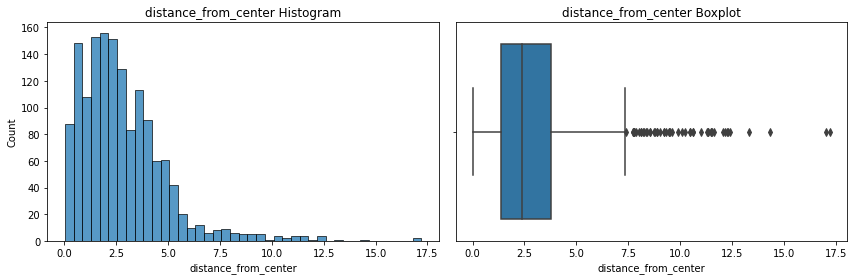

In [23]:
plots(unique_hotels, 'distance_from_center')

### Похоже на логнормальное распределение, попробуем логарифмировать данные.

In [24]:
# Логорифмируем данные
unique_hotels['distance_from_center'] = np.log(unique_hotels['distance_from_center'] + 1)

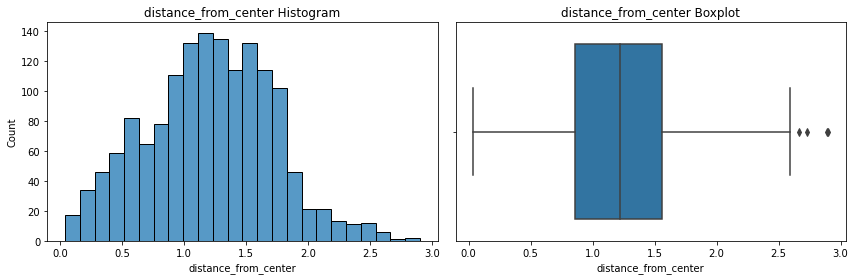

In [25]:
plots(unique_hotels, 'distance_from_center')

 ### Во, вот так уже получше, едем дальше.

In [26]:
# Закодируем город OneHotEncodding'ом
unique_hotels = pd.get_dummies(unique_hotels, columns=['hotel_city'])

In [27]:
# Дропнем лишние признаки
unique_hotels = unique_hotels.drop([

    'lat',
    'lng',
    'city_lat',
    'city_lng',
    'coordinates'], axis=1)

In [28]:
# Обогатим исходный сет новыми признаками
data = data.merge(unique_hotels, how='left', on='hotel_address')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

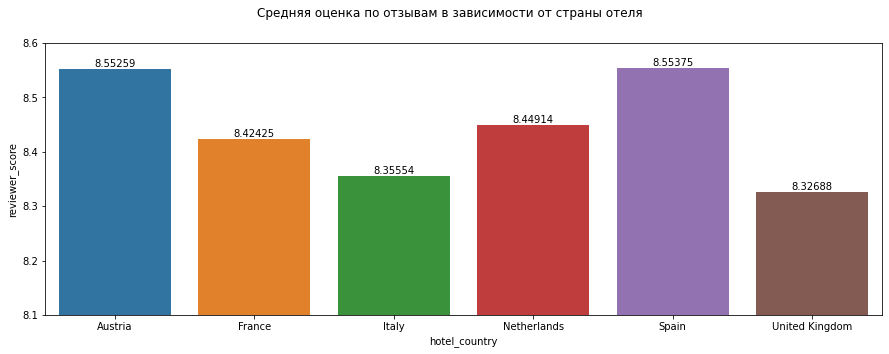

In [29]:
# Визуализируем среднюю оценку от страны
pivot_city = data[data['sample'] == 1][['hotel_country','reviewer_score']].groupby(
    'hotel_country').mean()
fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от страны отеля')
sns.barplot(x=pivot_city.index, y=pivot_city['reviewer_score'])
plt.ylim(8.1, 8.6)
ax.bar_label(ax.containers[0]);

In [30]:
# бэкап
data_4 = data.copy()

# 5. Признак `review_date` <a class="anchor" id=5></a> <a id="5"></a> <br>

[к содержанию](#0) 

## По признаку даты решим несколько задач:
### * Выделим месяцы и дни недели
### * Определим возраст отзывов в днях
### * Каким-нибудь прикольным способом закодируем полученные данные

In [31]:
# Приведем дату к формату Datetime
data['review_date'] = pd.to_datetime(data['review_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

In [32]:
# Определим возраст отзыва в днях от "сейчас"
data['days_from_today'] = (pd.Timestamp('today') - data['review_date']).dt.days

# Выделим месяц и день недели
data['month'] = data['review_date'].dt.month
data['day_of_week'] = data['review_date'].dt.dayofweek

In [33]:
# Выделим из признака days_since_review числа (дни)
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split(sep=' ')[0]).astype('int64')

In [34]:
# Закодируем кагериальные признаки "день недели" и "месяц"
data = pd.get_dummies(data, columns=['month','day_of_week'])

In [35]:
# сгруппируем по дням недели
day_0 = data[data['sample'] == 1].groupby('day_of_week_0')['reviewer_score'].mean()
day_1 = data[data['sample'] == 1].groupby('day_of_week_1')['reviewer_score'].mean()
day_2 = data[data['sample'] == 1].groupby('day_of_week_2')['reviewer_score'].mean()
day_3 = data[data['sample'] == 1].groupby('day_of_week_3')['reviewer_score'].mean()
day_4 = data[data['sample'] == 1].groupby('day_of_week_4')['reviewer_score'].mean()
day_5 = data[data['sample'] == 1].groupby('day_of_week_5')['reviewer_score'].mean()
day_6 = data[data['sample'] == 1].groupby('day_of_week_6')['reviewer_score'].mean()

# преобразуем в df для визуализации
day_of_week = pd.DataFrame({
    'пн':day_0,
    'вт':day_1,
    'ср':day_2,
    'чт':day_3,
    'пт':day_4,
    'сб':day_5,
    'вс':day_6,}).transpose()

# дропнем столбец 0, странно визуализаровать, какой была оценка "не в понедельник"
day_of_week.drop(0, axis=1)

,1
пн,8.394454
вт,8.444852
ср,8.409730
чт,8.347572
пт,8.370972
сб,8.370688
вс,8.397227


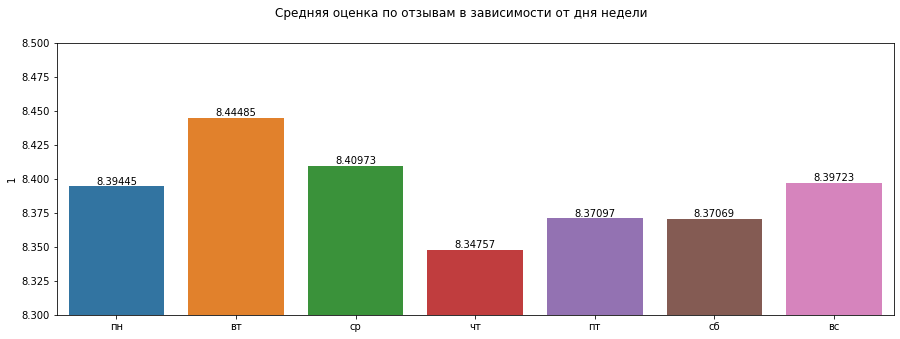

In [36]:
# Визуализируем среднюю оценку от дня недели
fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от дня недели')
sns.barplot(x=day_of_week.index, y=day_of_week[1])
plt.ylim(8.3, 8.5)
ax.bar_label(ax.containers[0]);

## Ну чтож вторник - хороший день, кто бы мог подумать..

In [37]:
# сгруппируем по дням недели
m_1 = data[data['sample'] == 1].groupby('month_1')['reviewer_score'].mean()
m_2 = data[data['sample'] == 1].groupby('month_2')['reviewer_score'].mean()
m_3 = data[data['sample'] == 1].groupby('month_3')['reviewer_score'].mean()
m_4 = data[data['sample'] == 1].groupby('month_4')['reviewer_score'].mean()
m_5 = data[data['sample'] == 1].groupby('month_5')['reviewer_score'].mean()
m_6 = data[data['sample'] == 1].groupby('month_6')['reviewer_score'].mean()
m_7 = data[data['sample'] == 1].groupby('month_7')['reviewer_score'].mean()
m_8 = data[data['sample'] == 1].groupby('month_8')['reviewer_score'].mean()
m_9 = data[data['sample'] == 1].groupby('month_9')['reviewer_score'].mean()
m_10 = data[data['sample'] == 1].groupby('month_10')['reviewer_score'].mean()
m_11 = data[data['sample'] == 1].groupby('month_11')['reviewer_score'].mean()
m_12 = data[data['sample'] == 1].groupby('month_12')['reviewer_score'].mean()

# преобразуем в df для визуализации
month = pd.DataFrame({
    'jan':m_1,
    'feb':m_2,
    'mar':m_3,
    'apr':m_4,
    'may':m_5,
    'jun':m_6,
    'jul':m_7,
    'aug':m_8,
    'sep':m_9,
    'oct':m_10,
    'nov':m_11,
    'dec':m_12}).transpose()

# дропнем столбец 0, странно визуализаровать, какой была оценка "не в понедельник"
month.drop(0, axis=1)

,1
jan,8.482867
feb,8.535112
mar,8.481804
apr,8.432337
may,8.386081
jun,8.387518
jul,8.339427
aug,8.413316
sep,8.294089
oct,8.262772


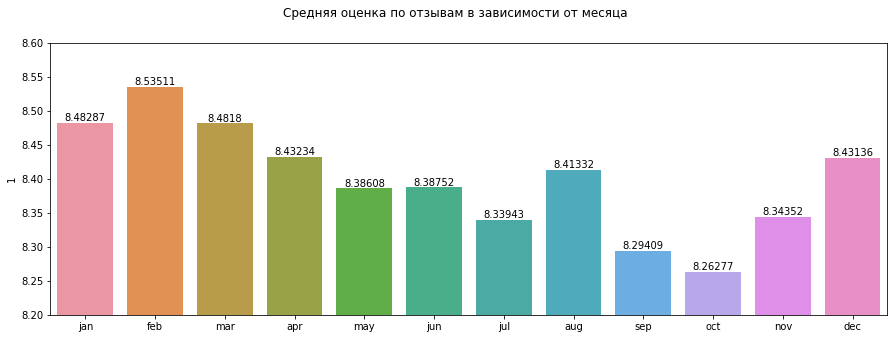

In [38]:
# Визуализируем среднюю оценку от месяца
fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от месяца')
sns.barplot(x=month.index, y=month[1])
plt.ylim(8.2, 8.6)
ax.bar_label(ax.containers[0]);

In [39]:
# backup
data_5 = data.copy()

## Февраль? Серьёзно? Кто любит путешествовать в феврале?

# 6. Признак `reviewer_nationality` <a class="anchor" id=6></a> <a id="6"></a> <br>

[к содержанию](#0) 

## По признаку национальности решим такие задачи:
### * Введём признак путешествия внутри своей страны / за границей
### * Введём признак религии
### * Введём признак англоговорящих стран
### * Закодируем признак национальности двоичным кодером

In [40]:
# Уберем лишние пробелы с начала и конца строки
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [41]:
%%time
# Добавим признак is_tourist где 1 - путешествие в другую страну, 0 - внутри своей
data['is_tourist'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['hotel_country'] else 0, axis=1)

CPU times: user 10.9 s, sys: 678 ms, total: 11.5 s
Wall time: 11.6 s


In [42]:
%%time
# Список стран где доминирующей религией является мусульманство
muslim_countries = ['Afghanistan','Albania','Algeria','All Countries',
    'Azerbaijan','Bahrain','Bangladesh','Brunei','Comoros','Djibouti','Egypt',
    'Gambia','Guinea','Indonesia','Iran','Iraq','Jordan','Kazakhstan','Kosovo',
    'Kuwait','Kyrgyzstan','Libya','Malaysia','Maldives','Mali','Mauritania',
    'Mayotte','Morocco','Niger','Oman','Pakistan','Palestinian territories',
    'Saudi Arabia','Senegal','Sierra Leone','Somalia','Sudan', 'Syria',
    'Tajikistan','Tunisia','Turkey','Turkmenistan','United Arab Emirates',
     'Uzbekistan','Western Sahara','Yemen']

# Введём признак is_muslim 1 - мусульманин, 0 - нет
data['is_muslim'] = data['reviewer_nationality'].apply(lambda x: 1 if x in muslim_countries else 0)

CPU times: user 586 ms, sys: 0 ns, total: 586 ms
Wall time: 587 ms


In [43]:
%%time
# Список ангоговорящих стран
en_lang = ['Antigua and Barbuda','The Bahamas','Barbados','Belize','Botswana','Burundi',
    'Cameroon','Canada','Dominica','Eswatini','Fiji','The Gambia','Ghana','Grenada',
    'Guyana','India','Ireland','Jamaica','Kenya','Kiribati','Lesotho','Liberia','Malawi',
    'Malta','Marshall Islands','Mauritius','Micronesia','Namibia','Nauru','Nigeria',
    'Pakistan','Palau','Papua New Guinea','The Philippines','Rwanda','Saint Kitts and Nevis',
    'Saint Lucia','Saint Vincent and the Grenadines','Samoa','Seychelles','Sierra Leone',
    'Singapore','Solomon Islands','South Africa','South Sudan','Sudan','Tanzania','Tonga',
    'Trinidad and Tobago','Tuvalu','Uganda','Vanuatu','Zambia','Zimbabwe','Australia',
    'New Zealand','United Kingdom','United States','Bahrain','Bangladesh','Bhutan','Cambodia',
    'Cyprus','Eritrea','Ethiopia','Israel','Jordan','Kuwait','Malaysia','Maldives','Myanmar',
    'Oman','Qatar','Sri Lanka','United Arab Emirates']

# Введём признак is_english 1 - yes, 0 - no
data['is_english'] = data['reviewer_nationality'].apply(lambda x: 1 if x in en_lang else 0)

CPU times: user 721 ms, sys: 0 ns, total: 721 ms
Wall time: 721 ms


In [44]:
%%time
# Закодируем признак reviewer_nationality двоичным кодированием
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

CPU times: user 459 ms, sys: 78 ms, total: 537 ms
Wall time: 538 ms


CPU times: user 711 ms, sys: 91.8 ms, total: 802 ms
Wall time: 782 ms


(7.6, 8.6)

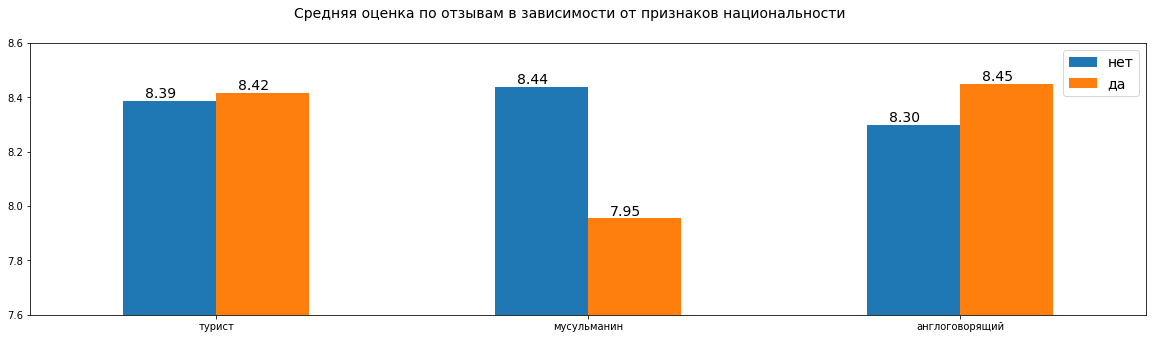

In [45]:
%%time
pivot_tour = data[data['sample'] == 1].groupby('is_tourist')['reviewer_score'].mean()
pivot_musl = data[data['sample'] == 1].groupby('is_muslim')['reviewer_score'].mean()
pivot_en = data[data['sample'] == 1].groupby('is_english')['reviewer_score'].mean()

pivot = pd.DataFrame({
    'турист':pivot_tour,
    'мусульманин':pivot_musl,
    'англоговорящий':pivot_en}).transpose()

fig, ax = plt.subplots(figsize=(20, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от признаков национальности', fontsize=14)
pplot = pivot.plot(ax=ax,
    kind='bar',  
    rot=0)

ax.legend(['нет', 'да'], loc='upper right', fontsize=14)

for p in pplot.patches:
    pplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=14)
    
plt.ylim(7.6, 8.6)

In [46]:
#backup
data_6 = data.copy()

# 7. Признак `tags` <a class="anchor" id=7></a> <a id="7"></a> <br>

[к содержанию](#0) 

## По признаку 'tags' сделаем следующее:
### * Получим список уникальных тегов
### * Закодируем значимые теги
### * Построим пару графиков

In [47]:
def tag_fixer(data):
    """Переделает теги, уберёт лишние пробелы и преобразует в список"""
    tags_fixed = []
    for tag in list(data.replace('[', '').replace(']', '').replace("'", '').split(',')):
        tag = tag.strip()
        tags_fixed.append(tag)
    return tags_fixed

In [48]:
%%time
# "починим" теги
data['tags'] = data['tags'].apply(tag_fixer)

CPU times: user 2.5 s, sys: 119 ms, total: 2.62 s
Wall time: 2.63 s


In [49]:
%%time
# получим список использованных тегов и наибольшее количество тегов "в ряд"
tags_list = []
max_tags_line = 0
for tags in data['tags']:
    tags_list.extend(tags)
    if len(tags) > max_tags_line:
        max_tags_line = len(tags)

CPU times: user 240 ms, sys: 1.03 ms, total: 241 ms
Wall time: 241 ms


In [50]:
print(f'Максимальное количество тегов в одном отзыве: {max_tags_line}\nКоличество уникальных тегов: {len(set(tags_list))}')

Максимальное количество тегов в одном отзыве: 6
Количество уникальных тегов: 2428


In [51]:
%%time
# посмотрим на ниболее популярные теги
tags_count = Counter(tags_list)
tags_count.most_common(20)


CPU times: user 232 ms, sys: 83 µs, total: 233 ms
Wall time: 231 ms


[('Leisure trip', 417538),
 ('Submitted from a mobile device', 307470),
 ('Couple', 252128),
 ('Stayed 1 night', 193568),
 ('Stayed 2 nights', 133850),
 ('Solo traveler', 108476),
 ('Stayed 3 nights', 95761),
 ('Business trip', 82884),
 ('Group', 65361),
 ('Family with young children', 60989),
 ('Stayed 4 nights', 47777),
 ('Double Room', 35207),
 ('Standard Double Room', 32247),
 ('Superior Double Room', 31361),
 ('Family with older children', 26334),
 ('Deluxe Double Room', 24812),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20826),
 ('Standard Double or Twin Room', 17479),
 ('Classic Double Room', 16877)]

### Пожно выделить следующие типы тегов:

 * Назначение поездки (работа / отдых)
 * Продолжительность пребывания
 * Количество гостей
 * Путешествие с животными
 * Отзыв написан с мобильного девайса
 * Вид номера (их овердохрена)

### Все теги (кроме видов номера) закодируем

In [52]:
%%time
# закодируем вид поездки
data['Leisure trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
data['Business trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

# продолжительность пребывания
data['Stayed 1 night'] = data['tags'].apply(lambda x: 1 if 'Stayed 1 night' in x else 0)
data['Stayed 2 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 2 nights' in x else 0)
data['Stayed 3 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 3 nights' in x else 0)
data['Stayed 4 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 4 nights' in x else 0)
data['Stayed 5 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 5 nights' in x else 0)
data['Stayed 6 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 6 nights' in x else 0)
data['Stayed 7 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 7 nights' in x else 0)
data['Stayed 8 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 8 nights' in x else 0)
data['Stayed 9 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 9 nights' in x else 0)
data['Stayed 10 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 10 nights' in x else 0)
data['Stayed 11-20 nights'] = data['tags'].apply(lambda x: 1 if ('Stayed 11 nights' in x) 
    or ('Stayed 12 nights' in x) or ('Stayed 13 nights' in x) or ('Stayed 14 nights' in x)
    or ('Stayed 15 nights' in x) or ('Stayed 16 nights' in x) or ('Stayed 17 nights' in x)
    or ('Stayed 18 nights' in x) or ('Stayed 19 nights' in x) or ('Stayed 20 nights' in x) else 0)
data['Stayed 21-31 nights'] = data['tags'].apply(lambda x: 1 if ('Stayed 21 nights' in x) 
    or ('Stayed 22 nights' in x) or ('Stayed 23 nights' in x) or ('Stayed 24 nights' in x)
    or ('Stayed 25 nights' in x) or ('Stayed 26 nights' in x) or ('Stayed 27 nights' in x)
    or ('Stayed 28 nights' in x) or ('Stayed 29 nights' in x) or ('Stayed 30 nights' in x) or ('Stayed 31 nights' in x) else 0)


# количество гостей
data['Solo traveler'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
data['Couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
data['Group'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)
data['Travelers with friends'] = data['tags'].apply(lambda x: 1 if 'Travelers with friends' in x else 0)
data['Family with young children'] = data['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)
data['Family with older children'] = data['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0)

# признак написания отзыва с мобильного устройства
data['Submitted from a mobile device'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

CPU times: user 6.37 s, sys: 42.1 ms, total: 6.41 s
Wall time: 6.42 s


In [53]:
def get_room_type(data):
    """классификатор вида номеров"""
    # сначала поищем класс номера
    result = None
    double = None
    for room in data:
        if 'Classic' in room:
            result = 'Classic'
        elif 'Guestroom' in room:
            result = 'Guestroom'
        elif 'Single' in room:
            result = 'Single'
        elif 'Standard' in room:
            result = 'Standard'
        elif 'Superior' in room:
            result = 'Superior'
        elif 'Comfort' in room:
            result = 'Comfort'
        elif 'Club' in room:
            result = 'Club'
        elif 'Suite' in room:
            result = 'Suite'
        elif 'Deluxe' in room:
            result = 'Deluxe'
        elif 'King' in room:
            result = 'King'
        elif 'Superior' in room:
            result = 'Superior'
        elif 'Premier' in room:
            result = 'Premier'
        elif 'without Window' in room:
            result = 'without Window'
        elif 'Queen' in room:
            result = 'Queen'
        elif 'Triple' in room:
            result = 'Triple'            
        elif 'Executive' in room:
            result = 'Executive'
        elif 'Large' in room:
            result = 'Large'    
        elif 'Luxury' in room:
            result = 'Luxury'            
        elif 'Studio' in room:
            result = 'Studio'
        elif 'Privilege' in room:
            result = 'Privilege' 
        elif 'Family Room' in room:
            result = 'Family Room'
        elif 'Quadruple' in room:
            result = 'Quadruple' 
            
    # теперь добавим отметку о 2х комнатности        
    for room in data:
        if 'Twin' in room or 'Double' in room or '2 rooms' in room:
            double = 'Double'
    # собирём вместе результат
    if result and double:
        return result+' '+double
    elif result and double is None:
        return result
    elif result is None and double:
        return double
    else:
        return 'Other'

In [54]:
%%time
# Определим основные типы комнат
data['room_type'] = data['tags'].apply(get_room_type)

# Закодируем их двоичным кодированием
bin_encoder = ce.BinaryEncoder(cols=['room_type']) 
type_bin = bin_encoder.fit_transform(data['room_type'])
data = pd.concat([data, type_bin], axis=1)

CPU times: user 2.75 s, sys: 167 ms, total: 2.91 s
Wall time: 2.92 s


In [55]:
#  введём условия
mask0 = data['sample'] == 1
mask1 = data['room_type'] == 'Double'
mask2 = data['room_type'] == 'Standard Double'
mask3 = data['room_type'] == 'Superior Double'
mask4 = data['room_type'] == 'Deluxe Double'
mask5 = data['room_type'] == 'Classic Double'
mask6 = data['room_type'] == 'Superior'
mask7 = data['room_type'] == 'Deluxe'
mask8 = data['room_type'] == 'Queen'
mask9 = data['room_type'] == 'Suite'
mask10 = data['room_type'] == 'King'

# получим средние оценки
r_1 = data[mask0 & mask1]['reviewer_score'].mean()
r_2 = data[mask0 & mask2]['reviewer_score'].mean()
r_3 = data[mask0 & mask3]['reviewer_score'].mean()
r_4 = data[mask0 & mask4]['reviewer_score'].mean()
r_5 = data[mask0 & mask5]['reviewer_score'].mean()
r_6 = data[mask0 & mask6]['reviewer_score'].mean()
r_7 = data[mask0 & mask7]['reviewer_score'].mean()
r_8 = data[mask0 & mask8]['reviewer_score'].mean()
r_9 = data[mask0 & mask9]['reviewer_score'].mean()
r_10 = data[mask0 & mask10]['reviewer_score'].mean()

# преобразуем в df для визуализации
rooms = pd.DataFrame({'reviewer_score':[r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,r_10]})
rooms.index = ['Double','Standard Double','Superior Double','Deluxe Double',
               'Classic Double','Superior','Deluxe','Queen','Suite','King']

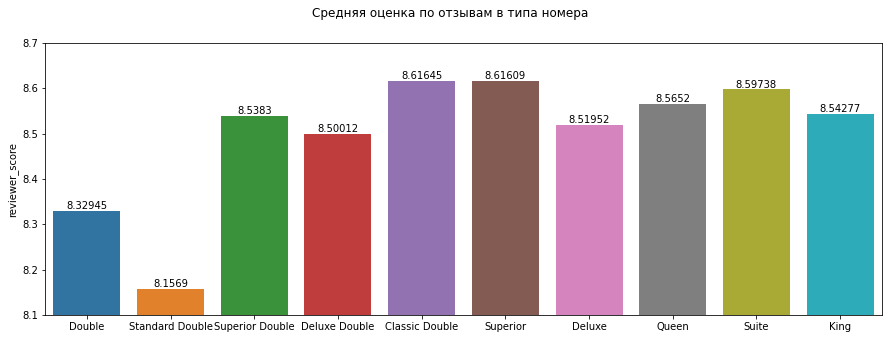

In [56]:
# Визуализируем среднюю оценку от типа комнаты
fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в типа номера')
sns.barplot(x=rooms.index, y=rooms['reviewer_score'])
plt.ylim(8.1, 8.7)
ax.bar_label(ax.containers[0]);

In [57]:
#  сформируем пул уникальных тегов
tags_set = set(tags_list)

# запишем теги с продолжительностью визита
days_tags = ['Stayed 1 night']
for day in range(2,32):
    days_tags.append('Stayed '+str(day)+' nights')
# список тегов которые уже закодированы
used_tags = ['Leisure trip','Business trip','Solo traveler','Couple','Group',
             'Family with young children','Submitted from a mobile device',
            'Family with older children','Travelers with friends' ]
used_tags.extend(days_tags)

# дропнем закодированные
for drop_tag in used_tags:
    tags_set.discard(drop_tag)

# дропнем теги связанные с видом номера
tags_set1 = tags_set.copy()
for tagg in tags_set:
    if 'room' in tagg:
        tags_set1.discard(tagg)
    elif 'Room'in tagg:
        tags_set1.discard(tagg)
    elif 'Suite'in tagg:
        tags_set1.discard(tagg)
    elif 'Apartment'in tagg:
        tags_set1.discard(tagg)
    elif 'Studio'in tagg:
        tags_set1.discard(tagg)
    elif 'Double'in tagg:
        tags_set1.discard(tagg)
    elif 'Deluxe'in tagg:
        tags_set1.discard(tagg)

# осталось 72 тега, ну и черт с ними
len(tags_set1)

72

In [58]:
# сгруппируем по продолжительности
m_1 = data[data['sample'] == 1].groupby('Stayed 1 night')['reviewer_score'].mean()
m_2 = data[data['sample'] == 1].groupby('Stayed 2 nights')['reviewer_score'].mean()
m_3 = data[data['sample'] == 1].groupby('Stayed 3 nights')['reviewer_score'].mean()
m_4 = data[data['sample'] == 1].groupby('Stayed 4 nights')['reviewer_score'].mean()
m_5 = data[data['sample'] == 1].groupby('Stayed 5 nights')['reviewer_score'].mean()
m_6 = data[data['sample'] == 1].groupby('Stayed 6 nights')['reviewer_score'].mean()
m_7 = data[data['sample'] == 1].groupby('Stayed 7 nights')['reviewer_score'].mean()
m_8 = data[data['sample'] == 1].groupby('Stayed 8 nights')['reviewer_score'].mean()
m_9 = data[data['sample'] == 1].groupby('Stayed 9 nights')['reviewer_score'].mean()
m_10 = data[data['sample'] == 1].groupby('Stayed 10 nights')['reviewer_score'].mean()
m_11 = data[data['sample'] == 1].groupby('Stayed 11-20 nights')['reviewer_score'].mean()
m_12 = data[data['sample'] == 1].groupby('Stayed 21-31 nights')['reviewer_score'].mean()


# преобразуем в df для визуализации
nights = pd.DataFrame({
    '1 night':m_1,
    '2 nights':m_2,
    '3 nights':m_3,
    '4 nights':m_4,
    '5 nights':m_5,
    '6 nights':m_6,
    '7 nights':m_7,
    '8 nights':m_8,
    '9 nights':m_9,
    '10 nights':m_10,
    '11-20 nights':m_11,
    '21-31 nights':m_12}).transpose()

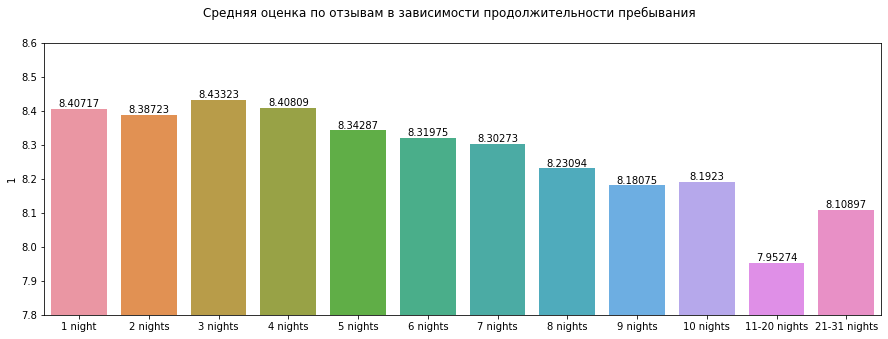

In [59]:
# Визуализируем среднюю оценку от продолжительности
fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости продолжительности пребывания')
sns.barplot(x=nights.index, y=nights[1])
plt.ylim(7.8, 8.6)
ax.bar_label(ax.containers[0]);

In [60]:
# сгруппируем по остальным тегам
t_1 = data[data['sample'] == 1].groupby('Leisure trip')['reviewer_score'].mean()
t_2 = data[data['sample'] == 1].groupby('Business trip')['reviewer_score'].mean()
t_3 = data[data['sample'] == 1].groupby('Solo traveler')['reviewer_score'].mean()
t_4 = data[data['sample'] == 1].groupby('Couple')['reviewer_score'].mean()
t_5 = data[data['sample'] == 1].groupby('Family with young children')['reviewer_score'].mean()
t_6 = data[data['sample'] == 1].groupby('Family with older children')['reviewer_score'].mean()
t_7 = data[data['sample'] == 1].groupby('Travelers with friends')['reviewer_score'].mean()
t_8 = data[data['sample'] == 1].groupby('Group')['reviewer_score'].mean()
t_9 = data[data['sample'] == 1].groupby('Submitted from a mobile device')['reviewer_score'].mean()



# преобразуем в df для визуализации
plottags = pd.DataFrame({
    'Leisure':t_1,
    'Business':t_2,
    'Solo':t_3,
    'Couple':t_4,
    'Young children':t_5,
    'Older children':t_6,
    'Friends':t_7,
    'Group':t_8,
    'Device':t_9}).transpose()

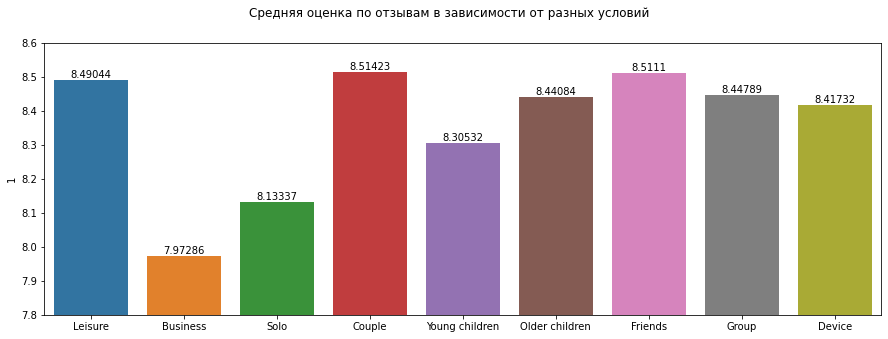

In [61]:
# Визуализируем среднюю оценку от всего подряд
fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от разных условий')
sns.barplot(x=plottags.index, y=plottags[1])
plt.ylim(7.8, 8.6)
ax.bar_label(ax.containers[0]);

In [62]:
#backup
data_7 = data.copy()

## Максимальные оценки ставят либо парочки на отдыхе либо отыхающие компание друзей. Логично чё.

# 8. Лингвистический анализ <a class="anchor" id=8></a> <a id="8"></a> <br>

[к содержанию](#0) 

## Работать будем с признаками `negative_review`, `positive_review`, и до кучи с количественными признаками по отзывам :
### * Посчитаем количества позитивных и негативных слов
### * Составим пропорцию длительности позитивного к негативному отзыву
### * Получим эмоциональные окраски отзывов
### * Еще что-нибудь, как-нибудь закодируем

In [63]:
%%time
# Посчитаем общее количество слов в позитивных и негативных отзывах 
data['review_total_word_counts'] = data['review_total_negative_word_counts'] + data['review_total_positive_word_counts']

# Введём пропорцию количество негативных / количество позитивных слов ( если слов нет установим значение 0.5)
data['review_words_proportion'] = data.apply(
    lambda x: 0.5 if x['review_total_word_counts'] == 0 \
    else (x['review_total_negative_word_counts']+1) / (x['review_total_positive_word_counts']+1), axis=1)

CPU times: user 13.9 s, sys: 1.09 s, total: 15 s
Wall time: 15 s


In [64]:
def get_text_pol(data):
    """доставатель настроения текста"""
    text = TextBlob(data)
    return text.sentiment[0]
    
def get_text_sub(data):
    """доставатель субьективности текста"""
    text = TextBlob(data)
    return text.sentiment[1]    

In [65]:
%%time
data['negative_polarity'] = data['negative_review'].apply(get_text_pol)
data['negative_subjectivity'] = data['negative_review'].apply(get_text_sub)
data['positive_polarity'] = data['positive_review'].apply(get_text_pol)
data['positive_subjectivity'] = data['positive_review'].apply(get_text_sub)

CPU times: user 8min 31s, sys: 329 ms, total: 8min 31s
Wall time: 8min 32s


In [66]:
%%time
# заменим текст отзывов на 0 или 1, если есть негативные или позитивные
data['negative_review'] = data['negative_review'].apply(lambda x: 0 if x=='No Negative' else 1)
data['positive_review'] = data['positive_review'].apply(lambda x: 0 if x=='No Positive' else 1)

CPU times: user 658 ms, sys: 1.99 ms, total: 660 ms
Wall time: 659 ms


In [67]:
%%time
# введём признак в котором умножим значение полярности на значение субъективности
data['negative_pol_sub'] = data['negative_polarity'] * data['negative_subjectivity']
data['positive_pol_sub'] = data['positive_polarity'] * data['positive_subjectivity']

CPU times: user 6.44 ms, sys: 0 ns, total: 6.44 ms
Wall time: 6.47 ms


In [68]:
#backup
data_8 = data.copy()

# 9. Отбор признаков <a class="anchor" id=9></a> <a id="9"></a> <br>

[к содержанию](#0)

## В этом разделе окончательно подготовим данные к загрузке в модель, для этого:
### * Дропнем всё что не числа
### * Разделим признаки на категориальные и числовые
### * Проверим на мультиколлинеарность
### * Проверим улучшится ли ключевая метка, если поиграть с числовыми признаками (стандартизация, нормализация, логорифмирование и прочее колдовство) 

In [69]:
# Определим столбцы на удаление
columns_to_drop = ['hotel_address','review_date','hotel_name','reviewer_nationality','tags','hotel_country','room_type','lat','lng']

In [70]:
# Удалим их
data = data.drop(columns_to_drop, axis=1)

In [71]:
%%time
# Проверим на пропуски и бесконечности
data.isin([np.inf, -np.inf, np.nan]).any().any()

CPU times: user 399 ms, sys: 285 ms, total: 685 ms
Wall time: 685 ms


False

CPU times: user 43.7 s, sys: 526 ms, total: 44.2 s
Wall time: 44 s


<AxesSubplot:>

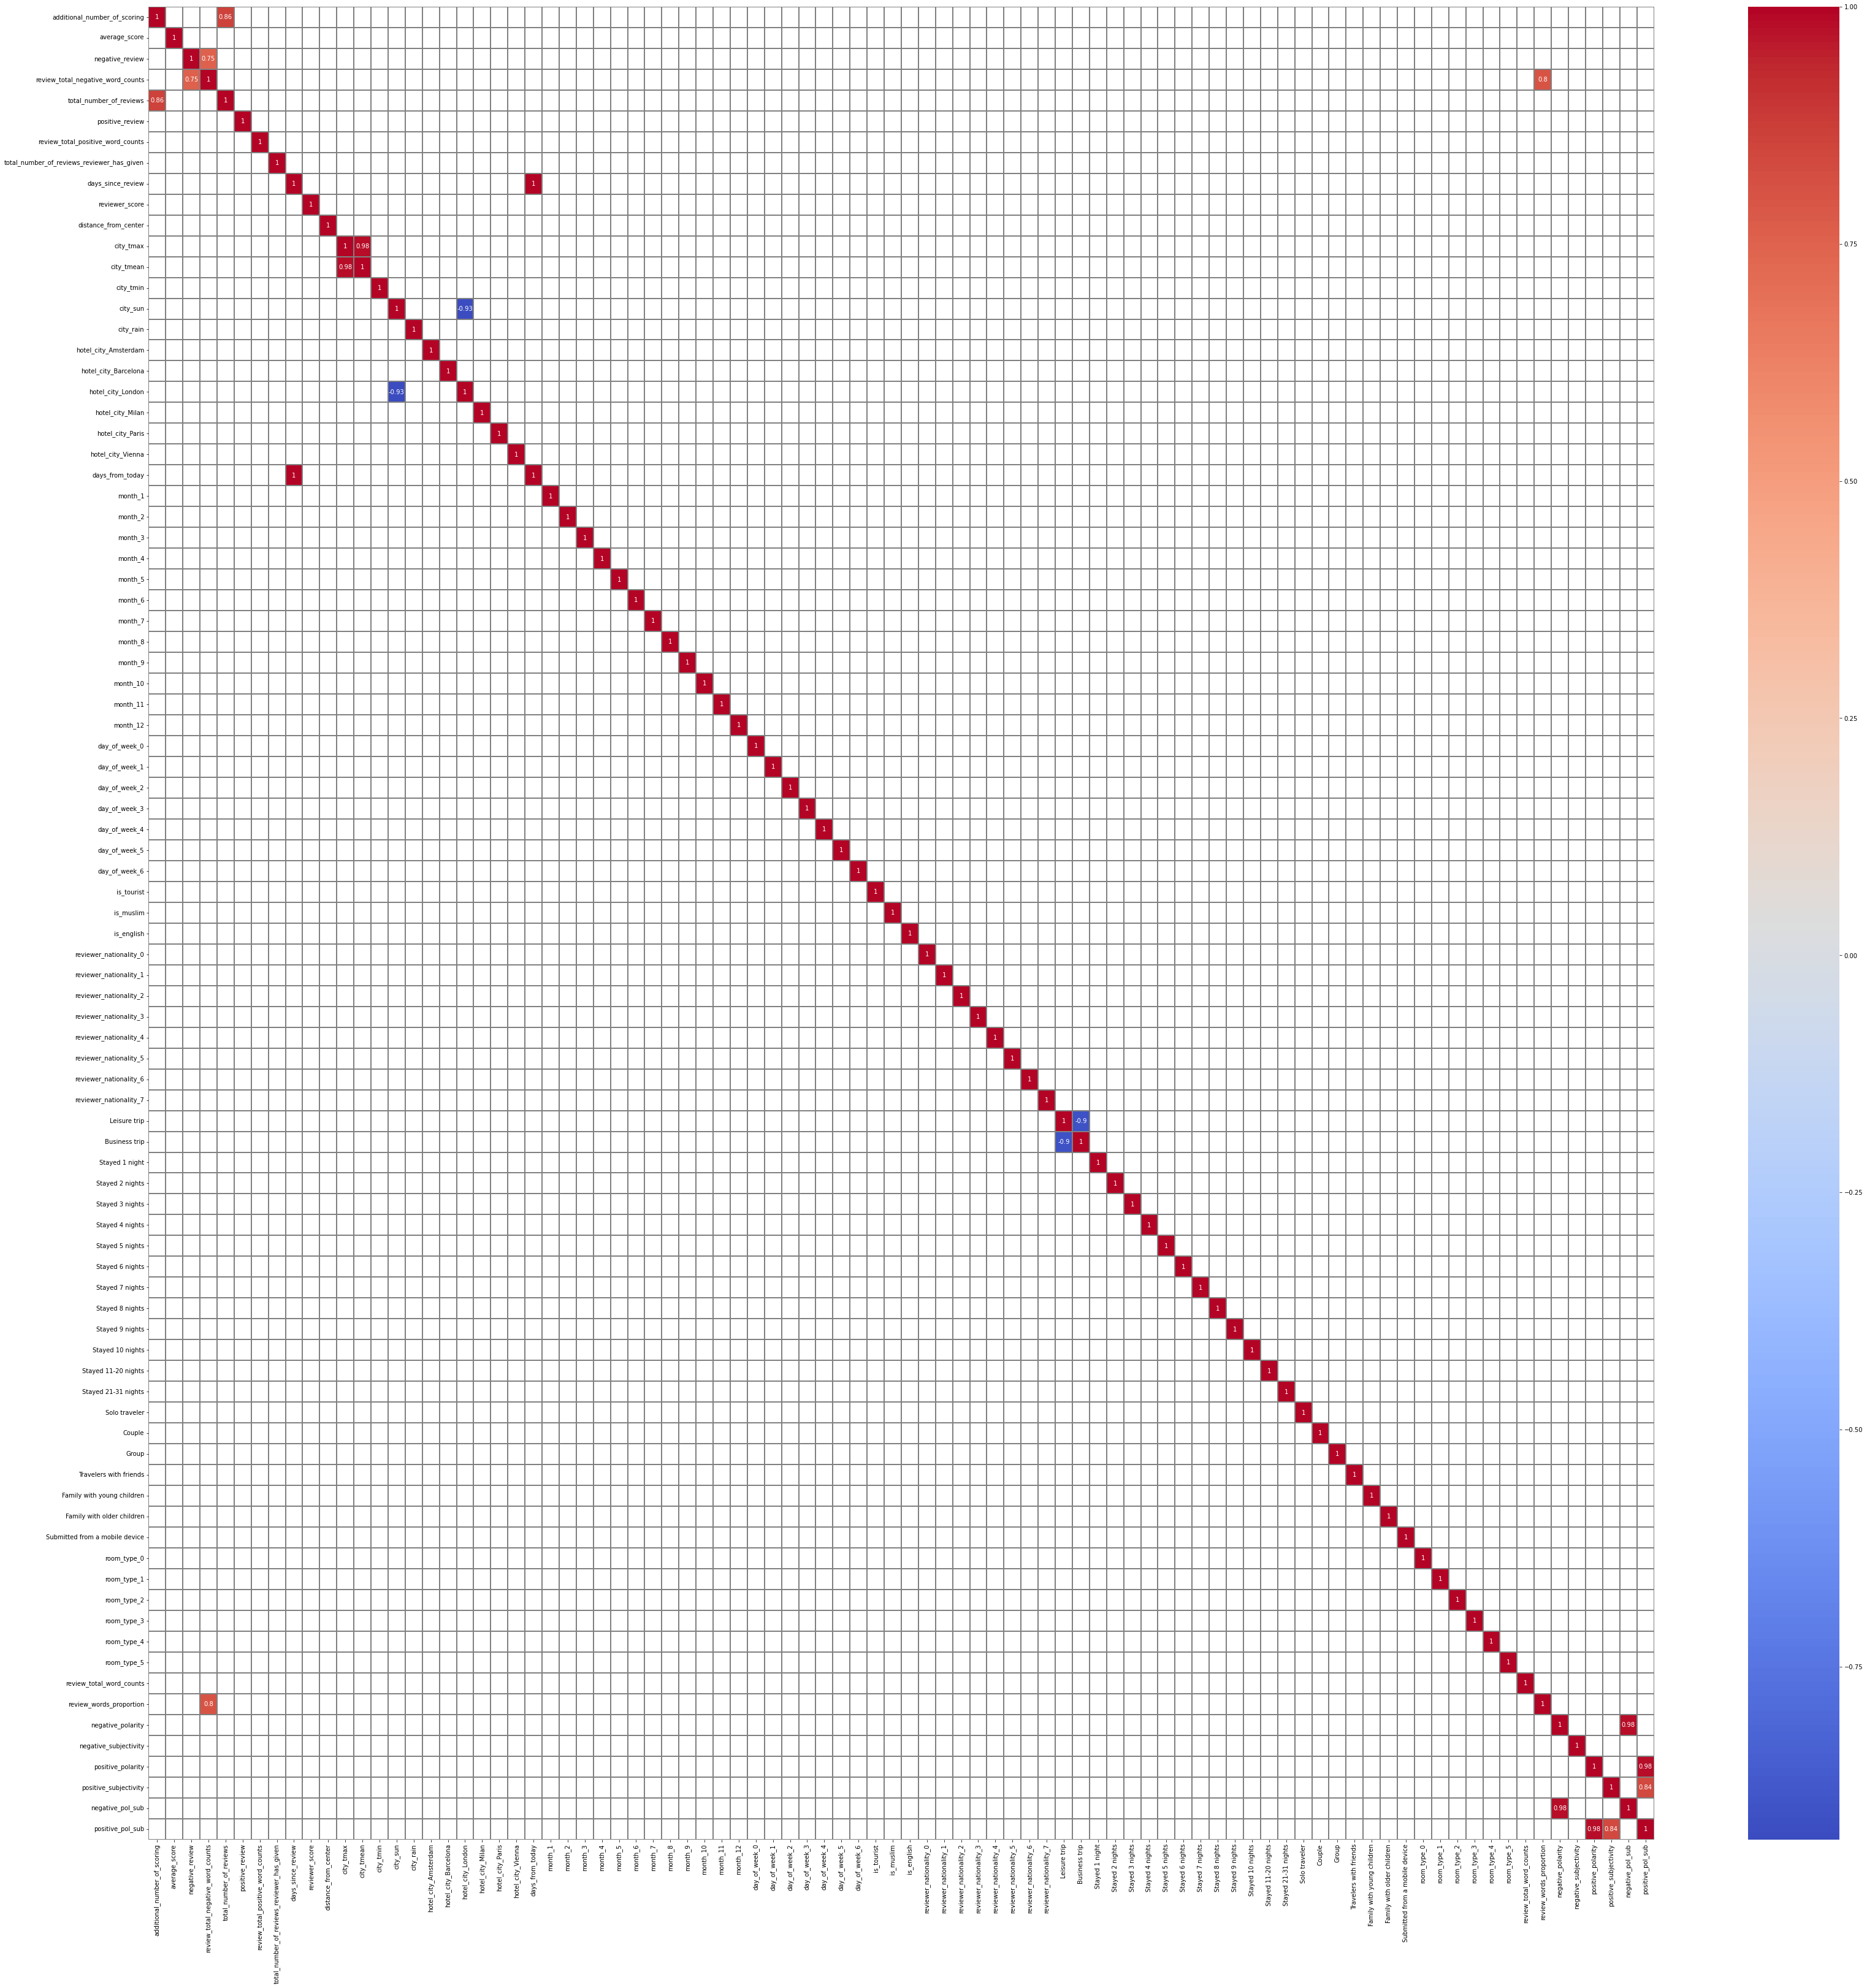

In [72]:
%%time
# Для корреляции с категориальными признаками будем использовать метод Спирмена
corr = data.drop(['sample'], axis=1).corr(method = 'spearman')

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.75
mask_2 = np.abs(corr) <= -0.75

corr_data = corr[mask_1 | mask_2]


# проверка признака на мультиколлинеарность
plt.rcParams['figure.figsize'] = (55,55)
sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray')
# sns.heatmap(corr, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray')

In [73]:
# Обозначим числовые признаки
num_cols = ['additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'distance_from_center',
    'city_tmax',
    'city_tmean',
    'city_tmin',
    'city_sun',
    'city_rain',
    'days_from_today',
    'review_total_word_counts',
    'review_words_proportion',
    'negative_polarity',
    'negative_subjectivity',
    'positive_polarity',
    'positive_subjectivity',
    'negative_pol_sub',
    'positive_pol_sub'
    ]

# Обозначим категориальные признаки
cat_cols = ['negative_review','positive_review','hotel_city_Amsterdam','hotel_city_Barcelona','hotel_city_London',
    'hotel_city_Milan','hotel_city_Paris','hotel_city_Vienna','month_1','month_2','month_3','month_4','month_5','month_6',
    'month_7','month_8','month_9','month_10','month_11','month_12','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3',
    'day_of_week_4','day_of_week_5','day_of_week_6','is_tourist','is_muslim','is_english','reviewer_nationality_0','reviewer_nationality_1',
    'reviewer_nationality_2','reviewer_nationality_3','reviewer_nationality_4','reviewer_nationality_5','reviewer_nationality_6',
    'reviewer_nationality_7','Leisure trip','Business trip','Stayed 1 night','Stayed 2 nights','Stayed 3 nights','Stayed 4 nights',
    'Stayed 5 nights','Stayed 6 nights','Stayed 7 nights','Stayed 8 nights','Stayed 9 nights','Stayed 10 nights','Stayed 11-20 nights',
    'Stayed 21-31 nights','Solo traveler','Couple','Group','Travelers with friends','Family with young children','Family with older children',
    'Submitted from a mobile device','room_type_0','room_type_1','room_type_2','room_type_3','room_type_4','room_type_5']

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>,
        <AxesSubplot:title={'center':'days_since_review'}>,
        <AxesSubplot:title={'center':'distance_from_center'}>,
        <AxesSubplot:title={'center':'city_tmax'}>,
        <AxesSubplot:title={'center':'city_tmean'}>],
       [<AxesSubplot:title={'center':'city_tmin'}>,
        <AxesSubplot:title={'center':'city_sun'}>,
        <AxesSubplot:title={'center':'city_rain'}>,
        <AxesSubplot:title={'center':'days_from_today'}>,
        <AxesSubplot:title={'center':'review_total_word_counts'}>],
       [<AxesSubplot:title={'center':'review_words_proporti

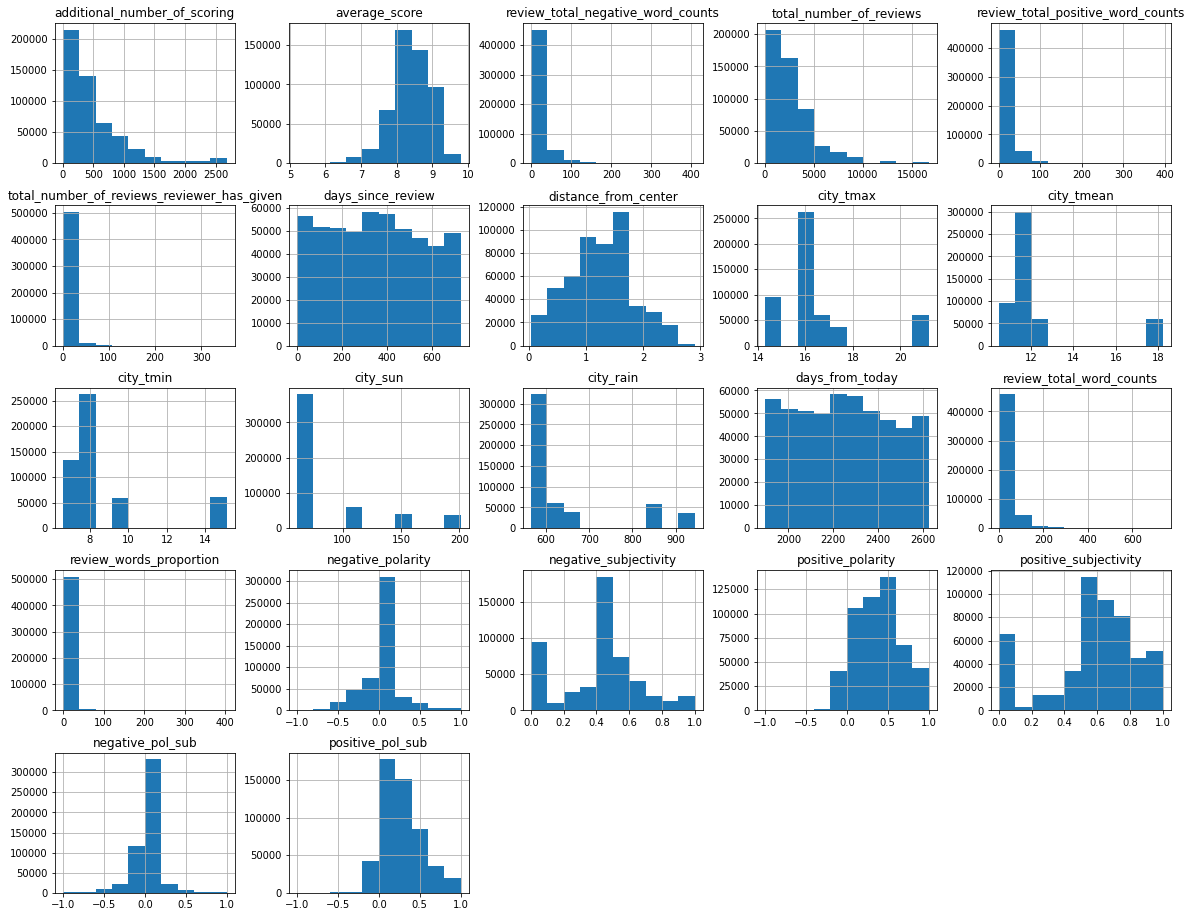

In [74]:
data[num_cols].hist(figsize=(20, 16))

In [75]:
%%time
# Логорифмируем данные
data['additional_number_of_scoring'] = np.log(data['additional_number_of_scoring'] + 1)
data['review_total_negative_word_counts'] = np.log(data['review_total_negative_word_counts'] + 1)
data['total_number_of_reviews'] = np.log(data['total_number_of_reviews'] + 1)
data['total_number_of_reviews'] = np.log(data['total_number_of_reviews'] + 1)
data['review_total_positive_word_counts'] = np.log(data['review_total_positive_word_counts'] + 1)
data['total_number_of_reviews_reviewer_has_given'] = np.log(data['total_number_of_reviews_reviewer_has_given'] + 1)
data['city_tmax'] = np.log(data['city_tmax'] + 1)
data['city_tmean'] = np.log(data['city_tmean'] + 1)
data['city_tmin'] = np.log(data['city_tmin'] + 1)
data['review_total_word_counts'] = np.log(data['review_total_word_counts'] + 1)
data['review_words_proportion'] = np.log(data['review_words_proportion'] + 1)

CPU times: user 218 ms, sys: 208 ms, total: 426 ms
Wall time: 425 ms


array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>,
        <AxesSubplot:title={'center':'days_since_review'}>,
        <AxesSubplot:title={'center':'distance_from_center'}>,
        <AxesSubplot:title={'center':'city_tmax'}>,
        <AxesSubplot:title={'center':'city_tmean'}>],
       [<AxesSubplot:title={'center':'city_tmin'}>,
        <AxesSubplot:title={'center':'city_sun'}>,
        <AxesSubplot:title={'center':'city_rain'}>,
        <AxesSubplot:title={'center':'days_from_today'}>,
        <AxesSubplot:title={'center':'review_total_word_counts'}>],
       [<AxesSubplot:title={'center':'review_words_proporti

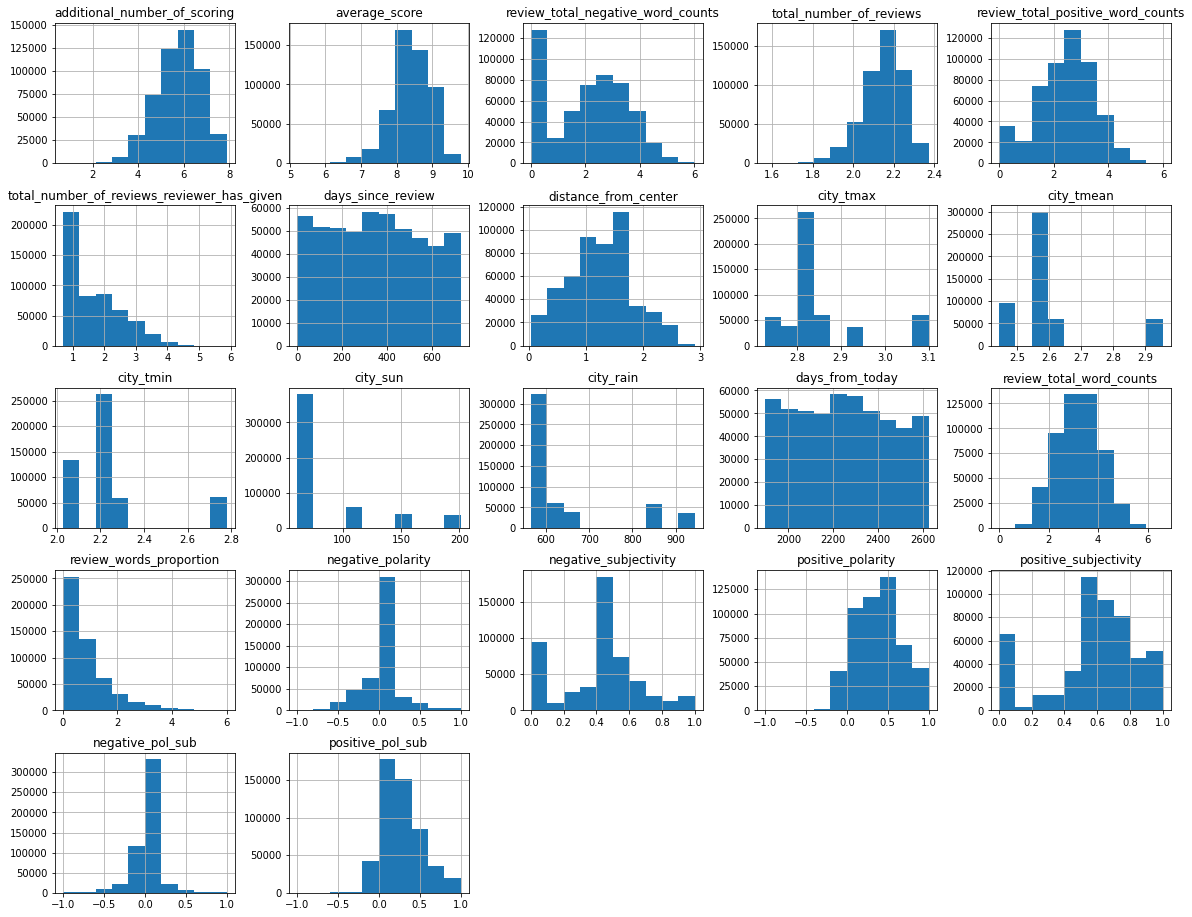

In [76]:
data[num_cols].hist(figsize=(20, 16))

# Отсюда начнём пихать в модель разные данные и смотреть как изменится метрика.

## Step_1

### * Контрольный (нет доп. очистки и доп. обработки) MAPE: 12.74
### * Удалим мультиколлинеарные признаки MAPE: 12.779939207479895 - стало хуже. вернём всё в зад.
### * Логорифмируем данные распределённые логнормально MAPE: 12.739906486321675 - чуть лучше контрольки. берём этот вариант.
### * Стандартизируем числовые данные MAPE: 12.740530691224134 - чуть хуже контрольки.
### *** Нормализуем числовые данные (после логорифмирования) MinMax МАРЕ: 12.739578402373905**
### * Нормализуем числовые данные Robust МАРЕ: 12.740060476197185 - чуть хуже, вернёмся к МинМакс скалеру.
### * Если стандартизировать данные после нормализации МАРЕ: 12.740530691224134 - чуть хуже, не будем стандартизировать.

## Step_2

### *** Контрольный MAPE: 12.739578402373905**
### * С удалением признаков со значимостью < 250 MAPE: 12.751361683049264 - разочарование.
### * С удалением признаков со значимостью < 350 MAPE: 12.777404673536669 - ясно, бл..
### * С удалением признаков со значимостью < 150 MAPE: 12.74567173911459 - удаление признаков не работает.

## Все дальнейшие преобразования только ухудшали метрику, поэтому принято решение удовлетворится довольно позорным 90-м местом в лидерборде.
## Возможно, когда я научусь более крутым штукам, я вернусь сюда и улучше метрику, а возможно..

<img src=https://raw.githubusercontent.com/hoittoken/Python/master/Py/project_3/mem_2.png>

In [77]:
# backup
data_9 = data.copy()

In [78]:
%%time
from sklearn import preprocessing
# инициализируем нормализатор 
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
data[num_cols] = mm_scaler.fit_transform(data[num_cols])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data[num_cols] = pd.DataFrame(data[num_cols])

CPU times: user 291 ms, sys: 187 ms, total: 478 ms
Wall time: 477 ms


In [79]:
data.isin([np.inf, -np.inf, np.nan]).any().any()

False

# 10. Обучение модели. Метрика. Submission <a class="anchor" id=10></a> <a id="8"></a> <br>

[к содержанию](#0)

## В модель загружаем данные которые показали лучший результат (определённый на предыдущем этапе). 

In [80]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [81]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [82]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 88), (386496, 88), (386496, 87), (309196, 87), (77300, 87))

In [83]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [84]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [85]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s


CPU times: user 24min 6s, sys: 5.6 s, total: 24min 11s
Wall time: 6min 12s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [86]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8857738464855539
MAPE: 12.739578402373905


<AxesSubplot:>

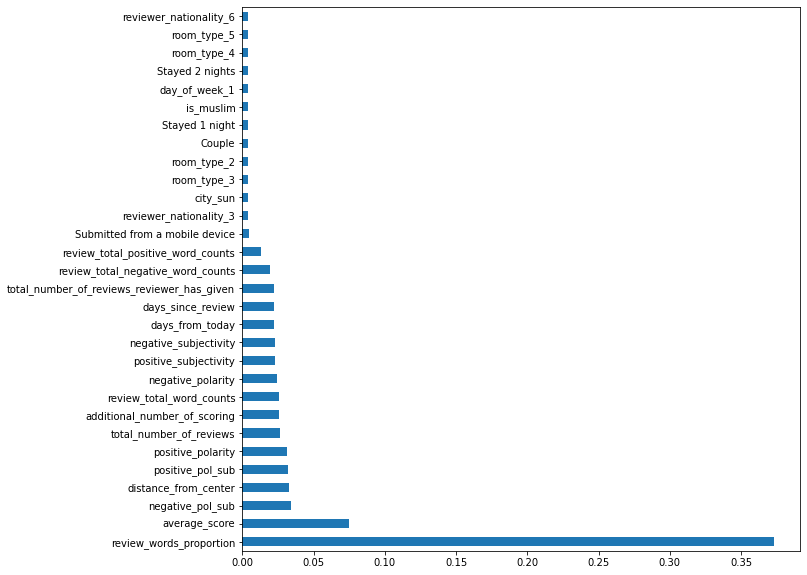

In [87]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [88]:
test_data.sample(10)

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,...,room_type_4,room_type_5,review_total_word_counts,review_words_proportion,negative_polarity,negative_subjectivity,positive_polarity,positive_subjectivity,negative_pol_sub,positive_pol_sub
90883,0.792484,0.717391,0,0.000000,0.824041,1,0.815058,0.078248,0.026027,0.0,...,0,0,0.738225,0.000835,0.575000,0.400000,0.651913,0.551531,0.530000,0.583785
93102,0.568537,0.673913,1,0.182684,0.618792,1,0.299554,0.528938,0.817808,0.0,...,1,1,0.314879,0.067158,0.500000,0.000000,0.500000,0.000000,0.500000,0.500000
77656,0.698522,0.608696,0,0.000000,0.807536,1,0.463534,0.212014,0.427397,0.0,...,0,1,0.419838,0.009674,0.575000,0.400000,0.725000,0.550000,0.530000,0.623750
83018,0.837582,0.847826,1,0.267628,0.843510,1,0.400891,0.345780,0.306849,0.0,...,0,1,0.410066,0.062029,0.375000,0.400000,0.750000,0.500000,0.450000,0.625000
78933,0.682676,0.695652,0,0.000000,0.793892,1,0.183671,0.000000,0.978082,0.0,...,0,1,0.166357,0.047524,0.575000,0.400000,0.800000,1.000000,0.530000,0.800000
76289,0.508719,0.804348,1,0.744521,0.498775,1,0.562960,0.546764,0.450685,0.0,...,1,0,0.719811,0.232093,0.562500,0.476250,0.700000,0.713333,0.529766,0.642667
2658,0.732560,0.565217,1,0.643729,0.704799,0,0.000000,0.290262,0.676712,0.0,...,0,1,0.586195,0.648332,0.396612,0.514304,0.443182,0.545455,0.446827,0.469008
50203,0.501409,0.739130,0,0.000000,0.543323,1,0.400891,0.133766,0.295890,0.0,...,1,1,0.363100,0.014072,0.575000,0.400000,0.718056,0.688889,0.530000,0.650216
116706,0.655825,0.543478,0,0.000000,0.700459,1,0.367342,0.000000,0.431507,0.0,...,0,1,0.332714,0.017131,0.575000,0.400000,0.850000,0.900000,0.530000,0.815000
68771,0.663625,0.717391,1,0.438840,0.614369,1,0.463534,0.632436,0.553425,0.0,...,0,0,0.509892,0.104356,1.000000,1.000000,0.820000,0.680000,1.000000,0.717600


In [89]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [90]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [91]:
test_data.shape

(128935, 87)

In [92]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.2s finished


In [93]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.663,488440
1,7.208,274649
2,8.453,374688
3,9.620,404352
4,9.364,451596
5,8.931,302161
6,8.271,317079
7,8.197,13963
8,8.630,159785
9,8.275,195089
